In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import torch
from ipywidgets import VBox, interactive_output, widgets
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math

from IPython.display import display
from viz import (
    get_slider_values,
    plot_enzyme_truth,
    plot_noisy_samples,
    create_enzyme_widgets,
    extract_widget_values,
    Colors,
    plot_gp_fit,
    plot_acquisition_function,
    plot_combined_gp_and_acquisition_from_results,
)
from kinetics import (
    symmetric_noise,
    enzyme_truth,
)

from bo import (
    generate_noisy_observations,
    fit_gp_model,
    perform_bo,
    transform_lengthscale_prior,
    transform_noise_prior,
)


SEED = 12345

## Crude Extract
Assume we handle an unknown product broth that has shown to produce a desired product in substantial quantities. The present enzymes and pathways responsible for the production of said product are unknown. In an effort to maximize the product formation, we would like to identify the ideal pH.

## Ground Truth
The kinetics of our different enzyme shall be modeled by Michaelis-Menten. 

$$
v_i = \frac{V_{\text{max},i} [S_i]}{K_{m,i} + [S_i]}
$$

The influence of pH on the maximum reaction rate can be modeled as a Gaussian-like effect.

$$
V_{\text{max},i}(pH) = V_{base,i} \exp\left(-\frac{(pH - pH_{\text{opt},i})^2}{2\sigma_i^2}\right)
$$

## Let's specify the ground truth

In [ ]:
bounds_pH = (3.5, 10.5)

pH_values = np.linspace(bounds_pH[0], bounds_pH[1], 500)

config = {
    "Enzyme_1": {
        "Vmax": {"min": 5, "max": 30, "step": 0.1, "value": 14.10},  # mM / min = U /ml
        "Km": {"min": 0.15, "max": 3, "step": 0.1, "value": 0.75},  # mM
        "pH_opt": {"min": 4.0, "max": 10.0, "step": 0.1, "value": 5.5},
        "sigma": {"min": 0.1, "max": 1.5, "step": 0.1, "value": 0.7},
    },
    "Enzyme_2": {
        "Vmax": {"min": 5, "max": 30, "step": 0.1, "value": 13.1},
        "Km": {"min": 0.15, "max": 3, "step": 0.1, "value": 1.0},
        "pH_opt": {"min": 4.0, "max": 10.0, "step": 0.1, "value": 7.2},
        "sigma": {"min": 0.1, "max": 2.0, "step": 0.1, "value": 0.5},
    },
    "Enzyme_3": {
        "Vmax": {"min": 5, "max": 30, "step": 0.1, "value": 13.5},
        "Km": {"min": 0.15, "max": 3, "step": 0.1, "value": 2.35},
        "pH_opt": {"min": 4.0, "max": 10.0, "step": 0.1, "value": 8.9},
        "sigma": {"min": 0.1, "max": 2.0, "step": 0.1, "value": 0.8},
    },
}

enzyme_widget, enzyme_sliders = create_enzyme_widgets(config=config)


def update_plot(**kwargs):
    enzyme_params = list(extract_widget_values(enzyme_sliders).values())
    plot_enzyme_truth(pH_values, enzyme_params)


slider_kwargs = {
    f"{param}_{i+1}": enzyme_sliders[f"Enzyme_{i+1}"][param]
    for i in range(len(config))
    for param in ["Vmax", "Km", "pH_opt", "sigma"]
}


interactive_plot = interactive_output(update_plot, slider_kwargs)

display(enzyme_widget, interactive_plot)

Output()

After fine-tuning the underlying ground truth of our system, we may select the observation noise for our synthetic case study.

In [3]:
# save ground truth parameters selected via widget
enzyme_params = list(extract_widget_values(enzyme_sliders).values())


sigma_0_slider = widgets.FloatSlider(value=0.7, min=0.1, max=5, step=0.1, description="Sigma_0")
sigma_1_slider = widgets.FloatSlider(value=0.8, min=0.1, max=5, step=0.1, description="Sigma_1")
max_noise_slider = widgets.FloatSlider(value=3, min=0.1, max=5, step=0.1, description="Max Noise")


noise_sliders = {
    "sigma_0": sigma_0_slider,
    "sigma_1": sigma_1_slider,
    "max_noise": max_noise_slider,
}


controls = VBox([sigma_0_slider, sigma_1_slider, max_noise_slider])


widget = interactive_output(
    plot_noisy_samples,
    {
        "sigma_0": sigma_0_slider,
        "sigma_1": sigma_1_slider,
        "max_noise": max_noise_slider,
        "bounds": widgets.fixed(bounds_pH),
        "enzyme_params": widgets.fixed(enzyme_params),
    },
)


display(VBox([controls, widget]))

In [4]:
# save noise parameters selected via widget
noise_params = get_slider_values(noise_sliders)

## With custom ground truth and observation noise - Let's obtain some data
Here, we select equidistant initial data points and obtain noisy observations.

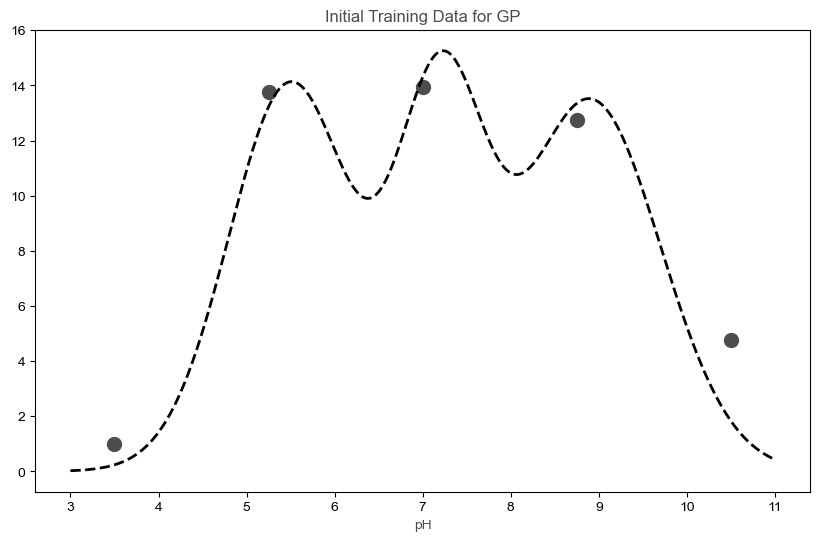

In [5]:
num_points = 5

# Use equidistant points for initial training data, make noisy observations
x_init = np.linspace(bounds_pH[0], bounds_pH[1], num_points)

y_init = generate_noisy_observations(
    x=x_init,
    bounds=bounds_pH,
    truth_fn=enzyme_truth,
    noise_fn=symmetric_noise,
    truth_params=enzyme_params,
    noise_params=noise_params,
    seed=SEED,
)

train_x = torch.tensor(x_init, dtype=torch.double).unsqueeze(-1)
train_y = torch.tensor(y_init, dtype=torch.double).unsqueeze(-1)


# Plot initial training data for reference
plt.figure(figsize=(10, 6))
plt.scatter(
    train_x.numpy(),
    train_y.numpy(),
    color=Colors.gray,
    label="Noisy Observations",
    s=100,
)
pH_range = np.linspace(3, 11, 500)


ground_truth, _ = enzyme_truth(
    pH_range,
    enzyme_params,
)
plt.plot(
    pH_range,
    ground_truth,
    color=Colors.black,
    label="Ground Truth",
    linewidth=2,
    linestyle="--",
)
plt.title("Initial Training Data for GP")
plt.xlabel("pH")
plt.show()

## Configure GP models
Utilizing the `GPyTorch` / `BoTorch` framework, we set up two GP models to demonstrate the influence of hyperparameter priors on model fitting. In both cases, we follow the established recommendations:

+ Mean function: zero-mean
+ Covariance function: squared exponential (RBF)

Furthermore, we apply the built-in input and output normalization and standardization routines provided by `BoTorch`to improve numerical stability.
These operations affect length scale and noise variance priors. Therefore, we apply helper functions to transform our hyperparameter priors accordingly.
Refer to `bo.py` for further insights. 

### Hyperparameter Priors
We encode a moderate expectation that the true function varies smoothly over about one-third of the total parameter range. Concretely, we center our length-scale prior at 1/3×(max–min) and use a moderately wide log-normal width (scale = 0.5) to allow some flexibility. For the noise variance, we assume our observations have 10 % relative measurement noise, centering the prior with low uncertainty (scale = 0.2).


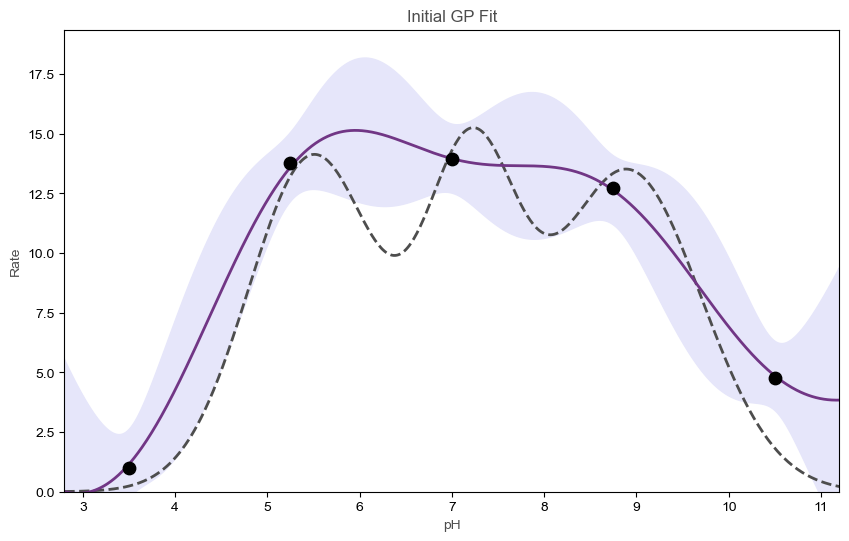

In [6]:
wf_ls_prior = transform_lengthscale_prior(
    raw_lengthscale=np.abs(bounds_pH[1] - bounds_pH[0]) / 3,
    bounds=bounds_pH,
    scale=0.5,
)

wf_noise_prior = transform_noise_prior(
    noise_val=0.1,
    y_train=train_y,
    scale=0.2,
)


def build_well_fit_gp(train_x, train_y):
    return fit_gp_model(
        train_x,
        train_y,
        bounds=bounds_pH,
        lengthscale_prior=wf_ls_prior,
        noise_prior=wf_noise_prior,
    )


well_fit_gp_model = build_well_fit_gp(train_x, train_y)


bounds_ax = (2.8, 11.2)

plot_gp_fit(
    gp_model=well_fit_gp_model,
    train_x=train_x,
    train_y=train_y,
    bounds=bounds_ax,
    ground_truth_fn=enzyme_truth,
    ground_truth_params=enzyme_params,
    title="Initial GP Fit",
    xlabel="pH",
    ylabel="Rate",
    plot_latest_observation=False,
)

### Poorly-Fitted GP
We encode a strong expectation that the true function is extremely smooth—varying only over the entire parameter range—by centering the length-scale prior at (max–min) and tightening the log-normal width (scale = 0.2). For the noise variance, we make an overly conservative assumption of 25 % relative measurement noise, using a very tight prior (scale = 0.1) to strongly enforce that belief.

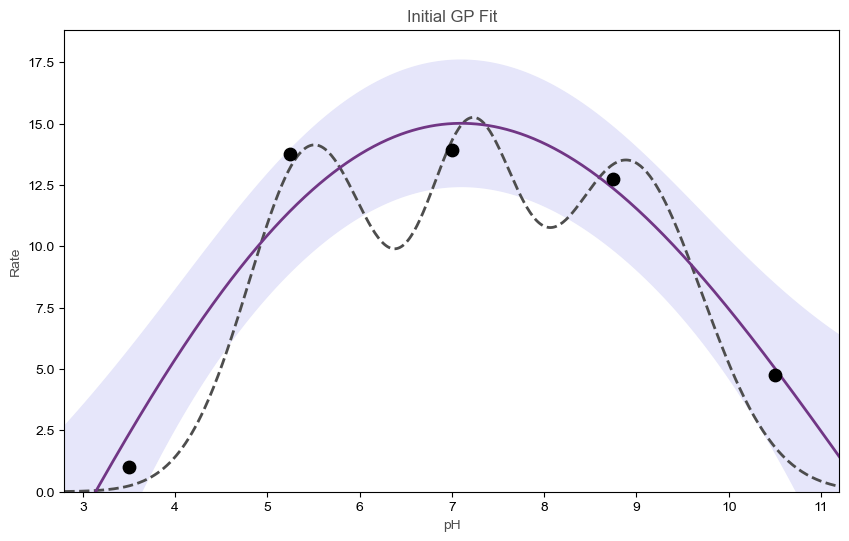

In [7]:
pf_ls_prior = transform_lengthscale_prior(
    raw_lengthscale=np.abs(bounds_pH[1] - bounds_pH[0]),
    bounds=bounds_pH,
    scale=0.2,
)

pf_noise_prior = transform_noise_prior(
    noise_val=0.25,
    y_train=train_y,
    scale=0.1,
)


def build_poorly_fit_gp(train_x, train_y):
    return fit_gp_model(
        train_x,
        train_y,
        bounds=bounds_pH,
        lengthscale_prior=pf_ls_prior,
        noise_prior=pf_noise_prior,
    )


poorly_fit_gp_model = build_poorly_fit_gp(train_x, train_y)

failed_fit = plot_gp_fit(
    gp_model=poorly_fit_gp_model,
    train_x=train_x,
    train_y=train_y,
    bounds=bounds_ax,
    ground_truth_fn=enzyme_truth,
    ground_truth_params=enzyme_params,
    title="Initial GP Fit",
    xlabel="pH",
    ylabel="Rate",
    plot_latest_observation=False,
)

### Comparison of both

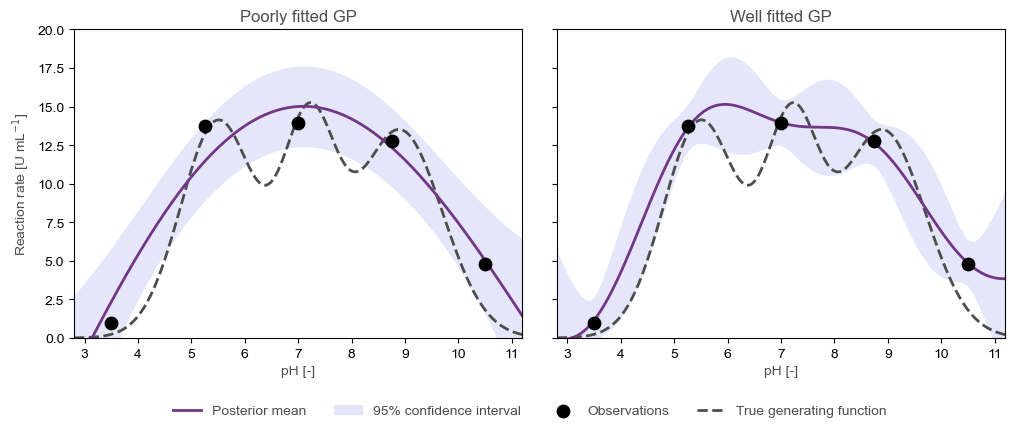

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
plt.tight_layout()

plot_gp_fit(
    gp_model=poorly_fit_gp_model,
    train_x=train_x,
    train_y=train_y,
    bounds=bounds_ax,
    ground_truth_fn=enzyme_truth,
    ground_truth_params=enzyme_params,
    ax=axes[0],
    title="Poorly fitted GP",
    xlabel="pH [-]",
    ylabel="Reaction rate [U mL$^{-1}$]",
    show_legend=False,
    plot_latest_observation=False,
)
axes[0].set_ylim(ymax=20)

plot_gp_fit(
    gp_model=well_fit_gp_model,
    train_x=train_x,
    train_y=train_y,
    bounds=bounds_ax,
    ground_truth_fn=enzyme_truth,
    ground_truth_params=enzyme_params,
    ax=axes[1],
    title="Well fitted GP",
    xlabel="pH [-]",
    show_ylabel=False,
    show_legend=False,
    plot_latest_observation=False,
)
axes[1].set_xlim(xmin=bounds_ax[0], xmax=bounds_ax[1])

handles, labels = axes[1].get_legend_handles_labels()


desired_order = [
    "Posterior mean",
    "95% confidence interval",
    "Observations",
    "True generating function",
]

# Build a mapping from label -> handle
label_to_handle = dict(zip(labels, handles))

# Reconstruct ordered lists of handles and labels
ordered_handles = []
ordered_labels = []
for lab in desired_order:
    h = label_to_handle.get(lab)
    if h is not None:
        ordered_handles.append(h)
        ordered_labels.append(lab)

# Finally draw one shared legend below both subplots:
fig.legend(
    ordered_handles,
    ordered_labels,
    loc="lower center",
    ncol=len(ordered_labels),  # or choose fewer columns to wrap into multiple rows
    frameon=False,
    bbox_to_anchor=(0.5, -0.05),
    borderaxespad=0.5,
)

# 3) Tighten up the bottom so it shows:
fig.subplots_adjust(bottom=0.18)

# 4) Save
plt.savefig("fit_comparison.pdf", bbox_inches="tight")

## Visualize BO iterations
After evaluating the influence of hyperparameter priors on the model fit, we select the appropriate GP configuration to perform multiple iterations of BO utilizing log expected improvement.

In [9]:
results_good = perform_bo(
    train_x=train_x,
    train_y=train_y,
    bounds=bounds_ax,
    num_candidates=1,
    num_rounds=8,
    truth_params=enzyme_params,
    noise_params=noise_params,
    method="logEI",
    gp_model_builder=build_well_fit_gp,
    seed=SEED,
)

results_bad = perform_bo(
    train_x=train_x,
    train_y=train_y,
    bounds=bounds_ax,
    num_candidates=1,
    num_rounds=8,
    truth_params=enzyme_params,
    noise_params=noise_params,
    method="logEI",
    gp_model_builder=build_poorly_fit_gp,
    seed=SEED,
)

plot_combined_gp_and_acquisition_from_results(
    results=results_good,
    bounds=bounds_ax,
    truth_fn=enzyme_truth,
    truth_params=enzyme_params,
)

Round 1/8
Round 2/8
Round 3/8
Round 4/8
Round 5/8
Round 6/8
Round 7/8
Round 8/8
Round 1/8
Round 2/8
Round 3/8
Round 4/8
Round 5/8
Round 6/8
Round 7/8
Round 8/8


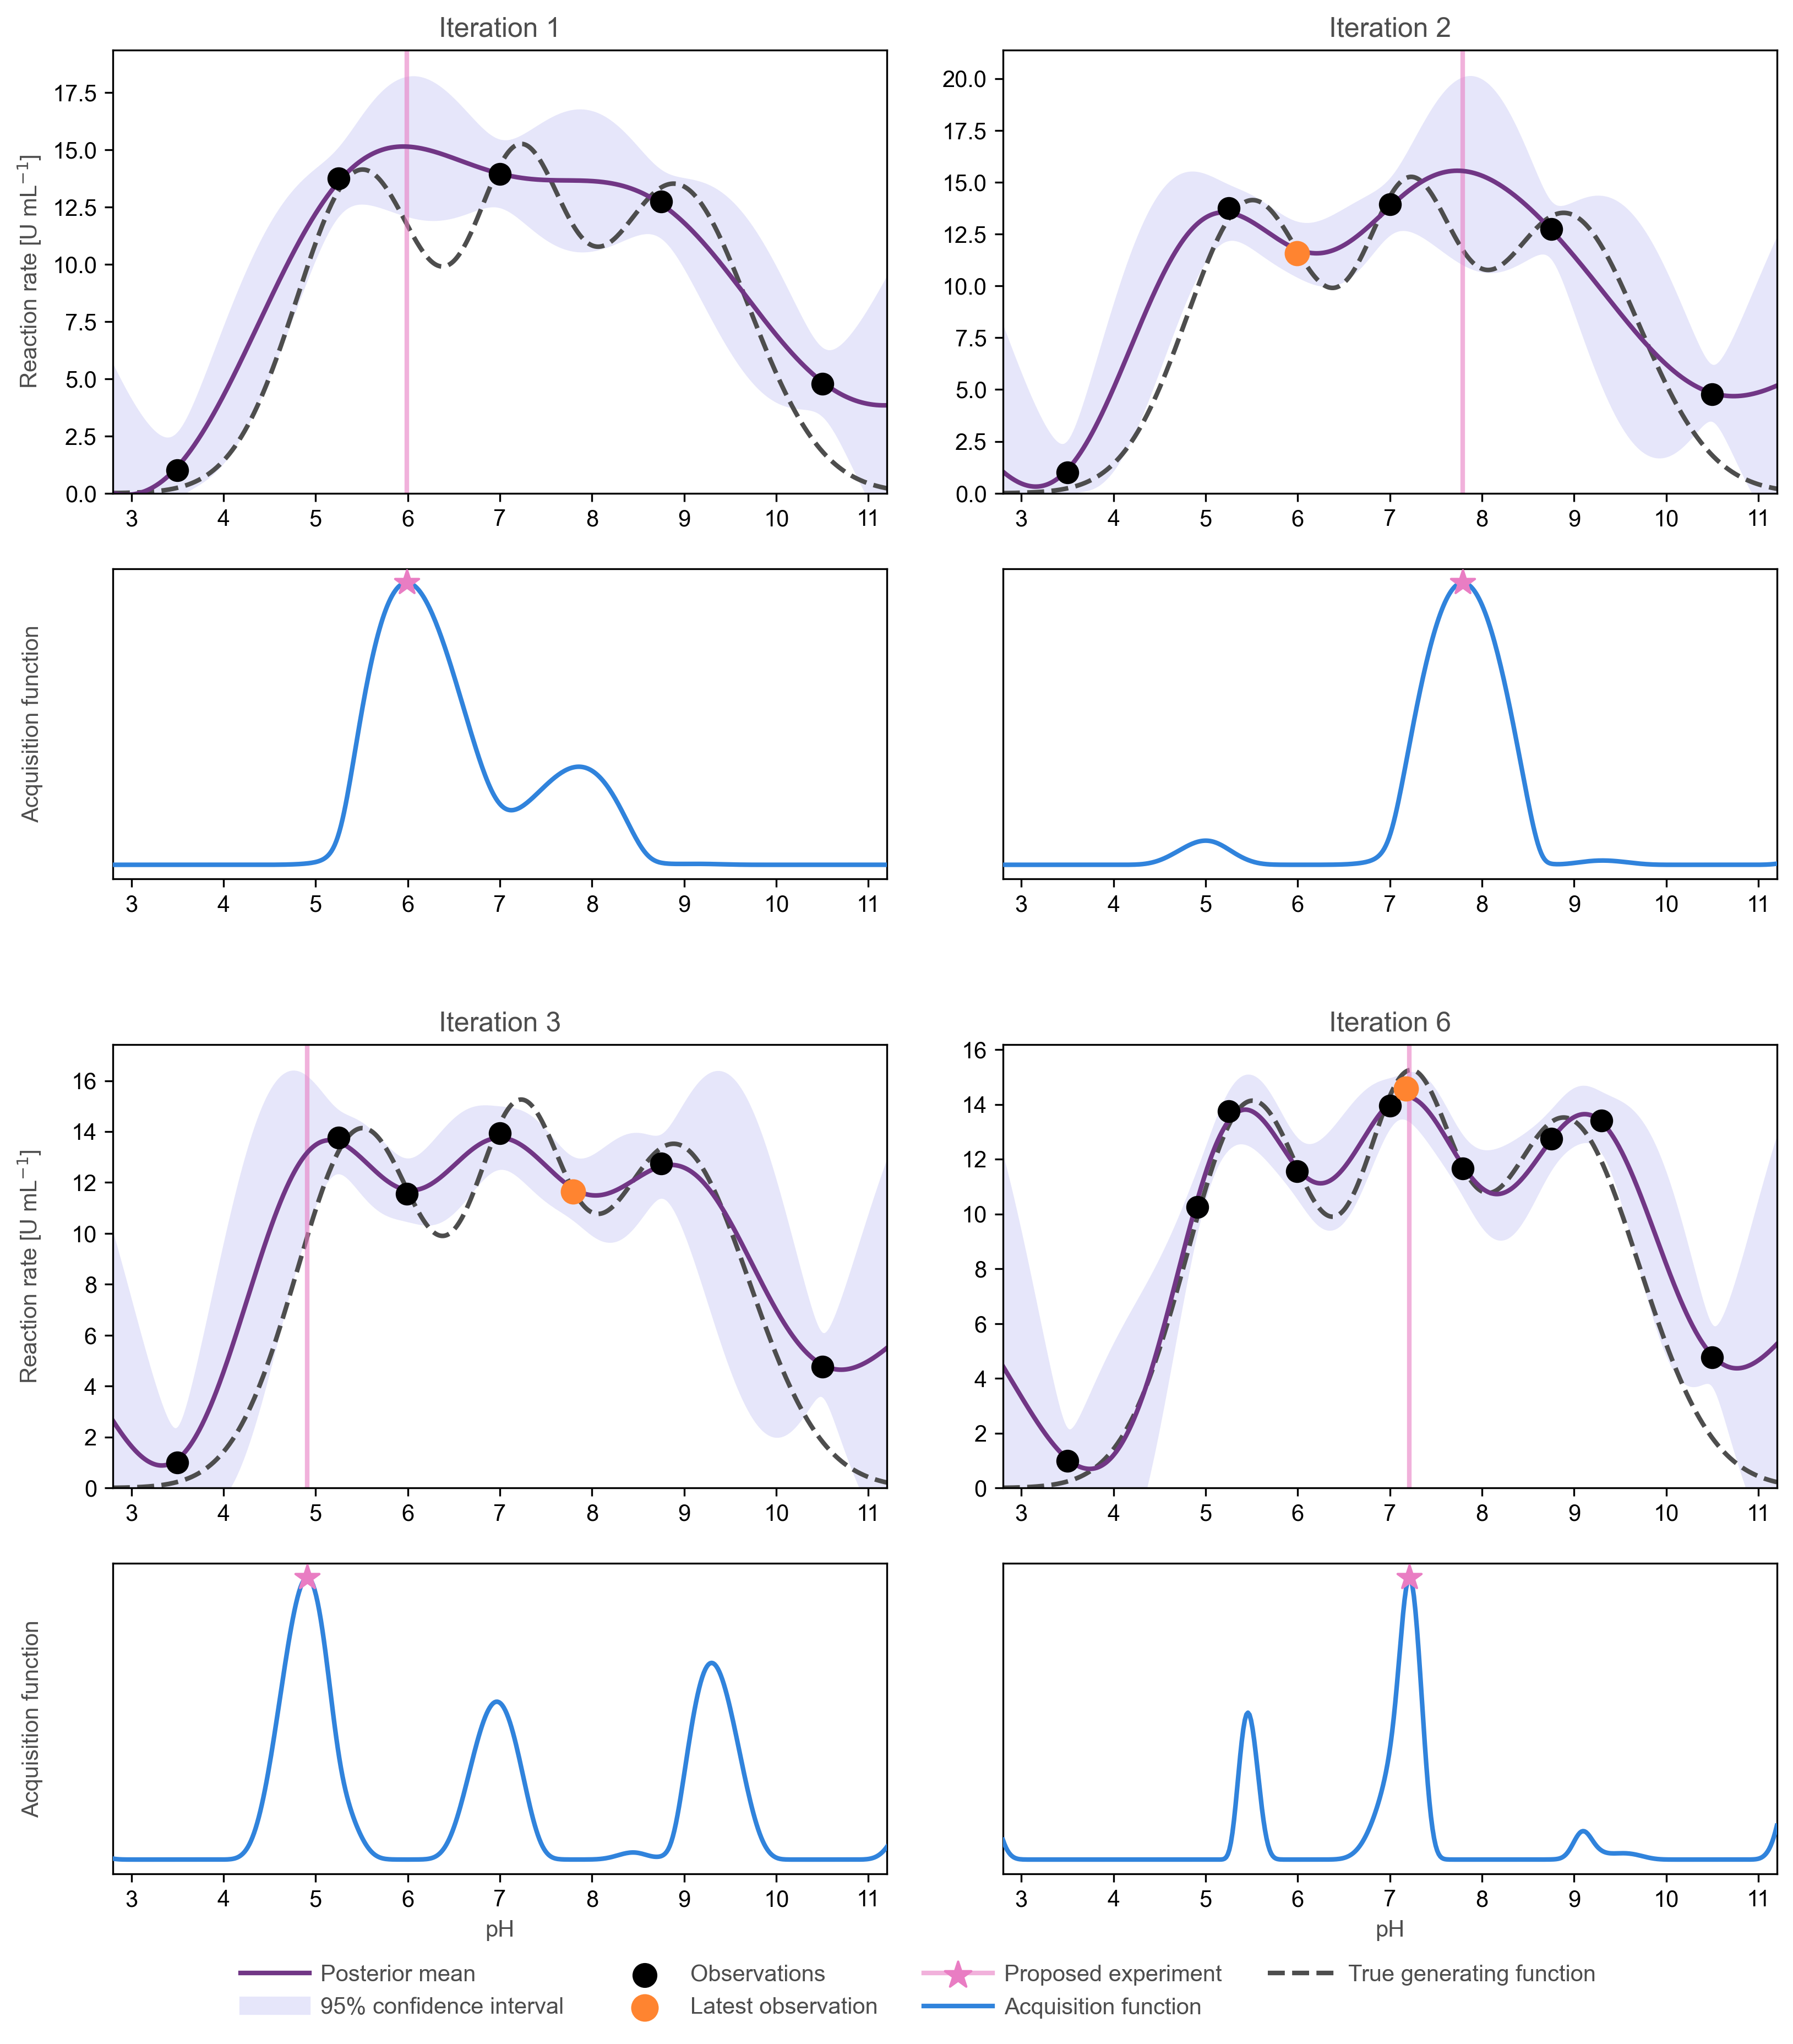

In [10]:
def plot_selected_rounds_2_columns(
    results, bounds, selected_rounds, truth_fn=None, truth_params=None
):
    """
    Plot GP + acquisition in 2‐column grid, no in‐axes legends,
    one shared legend in two rows with a single "Proposed experiment" entry.
    """
    gp_models = results["gp_models"]
    acquisition_fns = results["acquisition_fns"]
    train_x_per_round = results["train_x_per_round"]
    train_y_per_round = results["train_y_per_round"]
    candidates_per_round = results["candidates_per_round"]
    acquisition_vals = results["acquisition_vals"]

    # prepare custom layout for publication figure
    num = len(selected_rounds)
    rows = math.ceil(num / 2)
    fig = plt.figure(figsize=(13, 6 * rows), dpi=300)
    gs = gridspec.GridSpec(rows, 2, figure=fig, wspace=0.15, hspace=0.20)

    handles, labels = [], []

    for idx, r in enumerate(selected_rounds):
        show = idx == 0  # only first round labels
        col, row = idx % 2, idx // 2

        sub_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1, subplot_spec=gs[row, col], height_ratios=[1, 0.7], hspace=0.2
        )
        ax1 = fig.add_subplot(sub_gs[0])
        plot_gp_fit(
            gp_model=gp_models[r],
            train_x=train_x_per_round[r],
            train_y=train_y_per_round[r],
            bounds=bounds,
            ground_truth_fn=truth_fn,
            ground_truth_params=truth_params,
            highlight_points=(
                [(train_x_per_round[r][-1].item(), train_y_per_round[r][-1].item())]
                if r > 0
                else None
            ),
            proposed_experiment=candidates_per_round[r],
            ax=ax1,
            title=f"Iteration {r+1}",
            ylabel="Reaction rate [U mL$^{-1}$]" if col == 0 else None,
            xlabel=None,
            show_legend=show,  # ← pass to existing signature
        )

        ax2 = fig.add_subplot(sub_gs[1])
        plot_acquisition_function(
            acquisition_fn=acquisition_fns[r],
            candidates=candidates_per_round[r],
            bounds=bounds,
            ax=ax2,
            acquisition_vals=acquisition_vals[r],
            ylabel="Acquisition function" if col == 0 else None,
            xlabel="pH" if row == rows - 1 else None,
            show_legend=show,  # ← pass to existing signature
        )

        if show:
            h1, l1 = ax1.get_legend_handles_labels()
            h2, l2 = ax2.get_legend_handles_labels()
            handles += h1 + h2
            labels += l1 + l2

    # customize legend
    by_label = {}
    for h, lab in zip(handles, labels):
        by_label.setdefault(lab, []).append(h)

    desired_order = [
        "Posterior mean",
        "95% confidence interval",
        "Observations",
        "Latest observation",
        "Proposed experiment",  # will draw both line+star under one label
        "Acquisition function",
        "True generating function",
    ]

    final_handles = []
    final_labels = []
    for lab in desired_order:
        hs = by_label.get(lab, [])
        if not hs:
            continue
        if lab == "Proposed experiment":
            # merge the two handles (line + star) into a tuple
            final_handles.append(tuple(hs))
            final_labels.append(lab)
        else:
            # just take the first handle for everything else
            final_handles.append(hs[0])
            final_labels.append(lab)

    # whitespace manipulation
    fig.subplots_adjust(bottom=0.04, top=0.96)
    ncol = math.ceil(len(final_labels) / 2)
    fig.legend(
        final_handles,
        final_labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.00),
        ncol=ncol,
        frameon=False,
        handler_map={tuple: HandlerTuple()},
        markerscale=1.1,
        handlelength=3,
        handletextpad=0.5,
        borderaxespad=0.1,
    )

    # align left‐column y labels
    left_axes = [ax for ax in fig.axes if ax.get_ylabel()]
    fig.align_ylabels(left_axes)

    plt.savefig("bo_iterations.pdf", bbox_inches="tight")
    return fig


bo_plot = plot_selected_rounds_2_columns(
    results=results_good,
    bounds=bounds_ax,
    selected_rounds=[0, 1, 2, 5],
    truth_fn=enzyme_truth,
    truth_params=enzyme_params,
)